In [169]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6

# Introduction and Background

Can we quantify the quality of life with just a point on the map? We take a look at San Diego as sample, but this methodology could be applied to any neighborhood in the states. Using data such as the census and walkscore, we try to measure the ‘liveability’ of a neighborhood by looking at different aspects of the availability of methods of transportation rather than just more metrics such as an individual's level of education or income. 
	
A 2015 paper by Brian McKenzie of the US Census Bureau, “Transit Access and Population Change: The Demographic Profiles of Rail-Accessible Neighborhoods in the Washington, DC Area“, found that “young adults, recent movers, white workers, highly educated workers, and workers with high earnings all disproportionately live near rail stops” in Washington, DC and the five surrounding counties.
	
The implication is that there’s strong correlation between transportation infrastructure, housing prices, the availability of work, income, and economic mobility. We intend to probe the nature of this relationship to gauge, in particular, the role of transportation infrastructure in changing patterns of how people live and commute. We consider factors such as method of transportation, time of commute, and level of income across different data sets.
 
We hypothesize that when we control for things like population density and demographics, a more accessible public transportation leads to more economic mobility and higher standard of living.


Referencess:

* 1) Brian McKenzie. 2015. “Transit Access and Population Change: The Demographic Profiles of Rail-Accessible Neighborhoods in the Washington, DC Area.” SEHSD Working Paper No. 2015-023. U.S. Census Bureau. Washington, DC. https://www.census.gov/content/dam/Census/library/working-papers/2015/demo/SEHSD-WP2015-23.pdf

# Data Description

## WalkScore
<img src="walk-score-logo-large.png">

Walk Score data for each neighborhood in San Diego is scraped from Walk Score website (https://www.walkscore.com/CA/San_Diego) with the company's permission. Categories of information are as follows:

* Walk Score measures the walkability of any address based on the distance to nearby places and pedestrian friendliness
* Transit Score measures how well a location is served by public transit based on the distance and type of nearby transit lines.
* Bike Score measures whether an area is good for biking based on bike lanes and trails, hills, road connectivity, and destinations.

## Census Data

Census data for each census tract (sub-neighborhood divisions) is downloaded from the American FactFinder website (https://factfinder.census.gov). Categories of census data includes:

* Travel time to work
* Population
* Means of transportation to work (https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_15_5YR_S0802&prodType=table)
* Earnings
* Industry
* Race
* Sex

# Data Cleaning/Pre-processing

## Walk Score

Scrape the website

In [170]:
page = requests.get('https://www.walkscore.com/CA/San_Diego')
soup = BeautifulSoup(page.content, 'html.parser')
table = soup.table('tr')[1:]
wsdat = []
for entry in table:
    split = entry.get_text().split()
    #Retrieve data and make '-' results nans
    data = {
            'Neighborhood': ' '.join(split[1:-4]),
            'Population': int(split[-1].replace(',','')),
            'Walk': float(split[-4].replace('-','nan')),
            'Transit': float(split[-3].replace('-','nan')),
            'Bike': float(split[-2].replace('-','nan'))
        }
    wsdat.append(data)

In [171]:
ws = pd.DataFrame(wsdat)[['Neighborhood', 'Population',
                          'Walk', 'Transit', 'Bike']]

In [172]:
ws.head()

,Neighborhood,Population,Walk,Transit,Bike
0,Core-Columbia,5338,98.0,81.0,65.0
1,Horton Plaza,1474,97.0,81.0,82.0
2,Little Italy,3169,97.0,77.0,66.0
3,Gaslamp,976,97.0,80.0,77.0
4,Harborview,525,97.0,75.0,74.0


## Census 

### Tract populations


In [173]:
tract_pop = pd.read_csv('Data/Tract Populations/ACS_15_5YR_B01003_with_ann.csv',
                 skiprows = [0]).replace('-', 'nan')
tract_pop = tract_pop[['Geography', 'Estimate; Total']]
tract_pop.columns = ['Tract', 'Population']
tract_pop['Population'] = tract_pop['Population'].apply(pd.to_numeric, errors='coerce')
tract_pop.head()

,Tract,Population
0,"Census Tract 1, San Diego County, California",2716
1,"Census Tract 2.01, San Diego County, California",2223
2,"Census Tract 2.02, San Diego County, California",4683
3,"Census Tract 3, San Diego County, California",4875
4,"Census Tract 4, San Diego County, California",3606


### Tract commute times

In [174]:
tract_commutes = pd.read_csv('Data/Commute Time/ACS_15_5YR_B08303_with_ann.csv',
                             skiprows = [0]).replace('-', 'nan')
time_cols = tract_commutes.columns[np.where(['Estimate' in col for col in tract_commutes.columns])]
selection = np.hstack(['Geography', time_cols])
tract_commutes = tract_commutes[selection]
tract_commutes.columns = [
   'Tract', 
   'Commuters',
   'Commute Time Less than 5 minutes',
   'Commute Time 5 to 9 minutes',
   'Commute Time 10 to 14 minutes',
   'Commute Time 15 to 19 minutes',
   'Commute Time 20 to 24 minutes',
   'Commute Time 25 to 29 minutes',
   'Commute Time 30 to 34 minutes',
   'Commute Time 35 to 39 minutes',
   'Commute Time 40 to 44 minutes',
   'Commute Time 45 to 59 minutes',
   'Commute Time 60 to 89 minutes',
   'Commute Time 90 or more minutes'
]

Turn counts to percents


In [175]:
cols = tract_commutes.columns
tract_commutes = pd.concat(
    [
        tract_commutes[cols[0]], 
        tract_commutes[cols[2:]].div(tract_commutes['Commuters'], axis = 0),
    ],
    axis = 1
)
tract_commutes = tract_commutes.dropna().reset_index(drop=True)

Do columns sum to 1?

In [176]:
for i in range(len(tract_commutes)):
    assert np.isclose(tract_commutes.ix[i][1:].sum(),1)

Get average commute times

In [177]:
times = [(0+4)/2, (5+9)/2, (10+14)/2, (15+19)/2, (20+24)/2, (25+29)/2, (30+34)/2,
(35+39)/2, (40+44)/2, (45+59)/2, (60+89)/2, 90]

av = []
for i in range(len(tract_commutes)):
    av.append(np.dot(tract_commutes.ix[i][1:], times))
tract_commutes["Average Commute"] = av
tract_commutes = tract_commutes[['Tract', 'Average Commute']]
tract_commutes['Average Commute'] = tract_commutes['Average Commute'].apply(pd.to_numeric, errors='coerce')
tract_commutes.head()

,Tract,Average Commute
0,"Census Tract 1, San Diego County, California",23.716837
1,"Census Tract 2.01, San Diego County, California",26.637821
2,"Census Tract 2.02, San Diego County, California",21.924051
3,"Census Tract 3, San Diego County, California",25.027217
4,"Census Tract 4, San Diego County, California",23.399427


### Means of transportation to work

In [178]:
tract_transportation = pd.read_csv('Data/Transportation/ACS_15_5YR_S0802_with_ann.csv',
                             skiprows = [0]).replace('-', 'nan')

In [179]:
cols = [
    'Geography',
    'Total; Estimate; Workers 16 years and over',
    'Car, truck, or van -- drove alone; Estimate; Workers 16 years and over',
    'Car, truck, or van -- carpooled; Estimate; Workers 16 years and over',
    'Public transportation (excluding taxicab); Estimate; Workers 16 years and over'
]
other = tract_transportation[cols[1]] - tract_transportation[cols[2:]].sum(axis=1)
tract_transportation = pd.concat(
    [
        tract_transportation[cols[0]],
        tract_transportation[cols[2:]].div(tract_transportation[cols[1]], axis = 0),
        other.div(tract_transportation[cols[1]], axis = 0)
    ], 
    axis = 1
)
tract_transportation.columns = [
    'Tract',
    'Transportation Alone',
    'Transportation Carpool',
    'Transportation Public',
    'Transportation Other'
]
tract_transportation.head()

,Tract,Transportation Alone,Transportation Carpool,Transportation Public,Transportation Other
0,"Census Tract 1, San Diego County, California",0.767089,0.024473,0.000000,0.208439
1,"Census Tract 2.01, San Diego County, California",0.689289,0.032706,0.048242,0.229763
2,"Census Tract 2.02, San Diego County, California",0.786565,0.020516,0.033422,0.159497
3,"Census Tract 3, San Diego County, California",0.690596,0.021317,0.038245,0.249843
4,"Census Tract 4, San Diego County, California",0.695071,0.045530,0.149541,0.109858


Use logit of proportions as regressor

In [180]:
from scipy.special import logit as logit
transport_cols = ['Transportation Alone', 'Transportation Carpool',
                  'Transportation Public', 'Transportation Other']
tract_transportation[transport_cols] = tract_transportation[
                                    transport_cols].apply(logit)
tract_transportation.head()

,Tract,Transportation Alone,Transportation Carpool,Transportation Public,Transportation Other
0,"Census Tract 1, San Diego County, California",1.191944,-3.685425,-inf,-1.334362
1,"Census Tract 2.01, San Diego County, California",0.796796,-3.386929,-2.982080,-1.209651
2,"Census Tract 2.02, San Diego County, California",1.304344,-3.865810,-3.364561,-1.661975
3,"Census Tract 3, San Diego County, California",0.802905,-3.826721,-3.224760,-1.099448
4,"Census Tract 4, San Diego County, California",0.823935,-3.042773,-1.738209,-2.092193


Transportation time by mode of transportation (no statistically signifigant connections found)

In [181]:
# commute_time_by_mode = {'Tract': tract_transportation['Geography']}
# modes = ['drove alone', 'carpooled', 'Public']
# #Average time in each column. Cutting 60+ to 60 flat 
# times = [(0+9)/2, (10+14)/2, (15+19)/2, (20+24)/2, (25+29)/2, (30+34)/2, 
#  (35+44)/2, (45+59)/2, 60]

# for mode in modes:
#     cols = np.array(tract_transportation.columns.tolist())
#     #mask for desired columms
#     cols = [col for col in cols if mode in col and 'Estimate' in col and 'minutes' in col and 'Mean' not in col]
#     selected = tract_transportation[cols]
#     av = []
#     for i in range(len(alone)):
#         # '-' to nan
#         breakdown = np.array(['nan' if x == '-' else x for x in selected.ix[i].values])
#         av.append(np.dot(breakdown.astype(float)/100, times))
#     commute_time_by_mode['Average Commute ' + mode.title()] =  av
    
#     tract_transportation = pd.DataFrame(commute_time_by_mode)

### Income

In [182]:
tract_income = pd.read_csv('Data/Income/ACS_15_5YR_S1903_with_ann.csv',
                             skiprows = [0])
cols = tract_income.columns
tract_income = tract_income[['Geography', 'Median income (dollars); Estimate; Households']]
tract_income.columns = ['Tract', 'Median Income']
tract_income['Median Income'] = tract_income['Median Income'].apply(pd.to_numeric, errors='coerce')
tract_income.head()

,Tract,Median Income
0,"Census Tract 1, San Diego County, California",125370.0
1,"Census Tract 2.01, San Diego County, California",100436.0
2,"Census Tract 2.02, San Diego County, California",60929.0
3,"Census Tract 3, San Diego County, California",72979.0
4,"Census Tract 4, San Diego County, California",68099.0


### Rent

In [183]:
tract_rent = pd.read_csv('Data/Rent/ACS_15_5YR_B25064_with_ann.csv',
                             skiprows = [0])
tract_rent = tract_rent[['Geography', 'Estimate; Median gross rent']]
tract_rent.columns = ['Tract', 'Median Rent']
tract_rent['Median Rent'] = tract_rent['Median Rent'].apply(pd.to_numeric, errors='coerce')
tract_rent.head()

,Tract,Median Rent
0,"Census Tract 2.01, San Diego County, California",966.0
1,"Census Tract 2.02, San Diego County, California",1333.0
2,"Census Tract 3, San Diego County, California",1327.0
3,"Census Tract 4, San Diego County, California",1238.0
4,"Census Tract 5, San Diego County, California",1161.0


### Home Value

In [184]:
tract_home_value = pd.read_csv('Data/Home Value/ACS_15_5YR_B25077_with_ann.csv',
                             skiprows = [0])
tract_home_value = tract_home_value[['Geography', 'Estimate; Median value (dollars)']]
tract_home_value.columns = ['Tract', 'Median Home Value']
tract_home_value['Median Home Value'] = tract_home_value['Median Home Value'].apply(pd.to_numeric, errors='coerce')
tract_home_value.head()

,Tract,Median Home Value
0,"Census Tract 1, San Diego County, California",1038200.0
1,"Census Tract 2.01, San Diego County, California",754900.0
2,"Census Tract 2.02, San Diego County, California",589000.0
3,"Census Tract 3, San Diego County, California",498900.0
4,"Census Tract 4, San Diego County, California",433600.0


### Combining census data

In [185]:
census_tract_data = tract_pop.merge(tract_commutes, on = 'Tract')
census_tract_data = census_tract_data.merge(tract_transportation, on = 'Tract')
census_tract_data = census_tract_data.merge(tract_income, on = 'Tract')
census_tract_data = census_tract_data.merge(tract_rent, on = 'Tract')
census_tract_data = census_tract_data.merge(tract_home_value, on = 'Tract')

Renaming tracts to be more machine readable

In [186]:
for i, row in census_tract_data.iterrows():
    start = 13
    end = row.Tract.find(",")
    census_tract_data.set_value(i,'Tract',row.Tract[start:end])

In [187]:
census_tract_data.head()

,Tract,Population,Average Commute,Transportation Alone,Transportation Carpool,Transportation Public,Transportation Other,Median Income,Median Rent,Median Home Value
0,2.01,2223,26.637821,0.796796,-3.386929,-2.982080,-1.209651,100436.0,966.0,754900.0
1,2.02,4683,21.924051,1.304344,-3.865810,-3.364561,-1.661975,60929.0,1333.0,589000.0
2,3,4875,25.027217,0.802905,-3.826721,-3.224760,-1.099448,72979.0,1327.0,498900.0
3,4,3606,23.399427,0.823935,-3.042773,-1.738209,-2.092193,68099.0,1238.0,433600.0
4,5,2873,24.859375,1.621780,-3.789718,-3.284160,-2.124497,56750.0,1161.0,603000.0


## Combining WalkScores (Neighborhoods) with Census (Tracts)

Shapefiles for tracts and neighborhoods are compared to find overlaps

In [188]:
import shapefile

Neighborhood shapefiles

In [189]:
# neighborhood shapefile data from Zillow:
# https://www.zillow.com/howto/api/neighborhood-boundaries.htm
ca_neighborhoods = shapefile.Reader("Data/CA Neighborhoods/ZillowNeighborhoods-CA.shp")
ca_neighborhood_metadata = ca_neighborhoods.shapeRecords()

In [190]:
sd_neighborhood_shapes = []
sd_neighborhood_metadata = []
sd_neighborhood_names = []
for i in range(len(ca_neighborhood_metadata)):
    metadata = ca_neighborhood_metadata[i]
    if metadata.record[2] == 'San Diego': #San Diego City
        shape = ca_neighborhoods.shapes()[i]
        sd_neighborhood_shapes.append(shape)
        sd_neighborhood_metadata.append(metadata)
        sd_neighborhood_names.append(metadata.record[3])

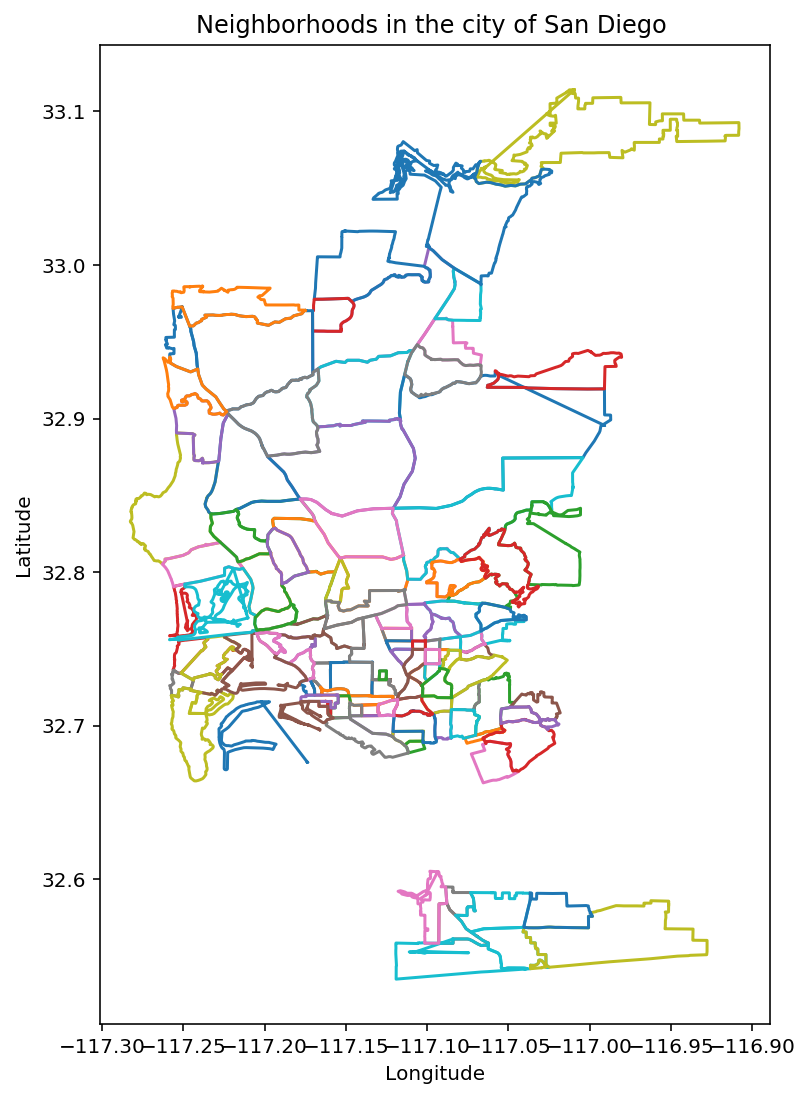

In [191]:
fig = plt.figure(figsize=(6,9))
for shape in sd_neighborhood_shapes:
    plt.plot(np.array(shape.points)[:,0], np.array(shape.points)[:,1])
plt.title('Neighborhoods in the city of San Diego ')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Tract shapefiles

In [192]:
#2015 census tracts
#https://www.census.gov/geo/maps-data/data/cbf/cbf_tracts.html
ca_tracts = shapefile.Reader("Data/CA Census Tracts/cb_2015_06_tract_500k.shp")
ca_tract_metadata = ca_tracts.shapeRecords()

In [193]:
sd_tract_shapes = []
sd_tract_metadata = []
for i in range(len(ca_tract_metadata)):
    metadata = ca_tract_metadata[i]
    if metadata.record[1] == '073': #San Diego county
        shape = ca_tracts.shapes()[i]
        sd_tract_shapes.append(shape)
        sd_tract_metadata.append(metadata)

Retrieve tract names from shapefile records

In [194]:
sd_tract_ids = []
for metadata in sd_tract_metadata:
    tract_id = metadata.record[2]
    start = str(int(tract_id[:-2]))
    end = tract_id[-2:]
    if end !='00':
        cleaned_id = '.'.join([start,end])
    else:
        cleaned_id = start
    sd_tract_ids.append(cleaned_id)

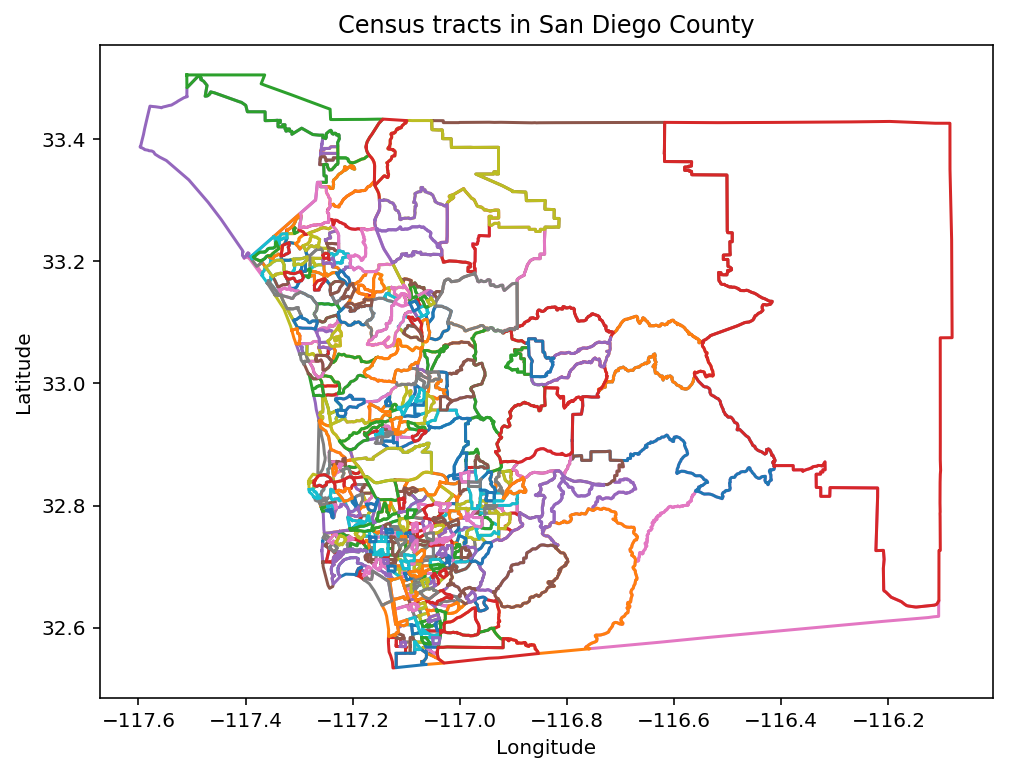

In [195]:
for shape in sd_tract_shapes:
    plt.plot(np.array(shape.points)[:,0], np.array(shape.points)[:,1])
plt.title('Census tracts in San Diego County')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

### Matching tracts and neighborhoods

In [196]:
import shapely
from shapely.geometry import Polygon

For each tract, which neighborhoods overlap it, and how much of its area do each of them cover?

In [197]:
tract_coverage = {tract_id: {'Neighborhoods': [], 'Coverage': [], 'Area': 0}
         for tract_id in sd_tract_ids}

for i in range(len(sd_tract_shapes)):
    tract_id = sd_tract_ids[i]
    tract_shape = sd_tract_shapes[i]
    tract_poly = Polygon(tract_shape.points).buffer(0)
    
    #Tract area, 
    area = tract_poly.area
    #Projection is approximately flat for small angles on globe. Measured in km
    tract_coverage[tract_id]['Area'] = area*(np.pi/180 * 6371**2) 
    for j in range(len(sd_neighborhood_shapes)):
        neighborhood_name = sd_neighborhood_names[j]
        neighborhood_shape = sd_neighborhood_shapes[j]
        neighborhood_poly = Polygon(neighborhood_shape.points).buffer(0)

        #Intersectional area
        intersect_area = tract_poly.intersection(neighborhood_poly).area
        coverage = 0 if area == 0 else intersect_area/area #Proportion
        if coverage > 0:
            tract_coverage[tract_id]['Neighborhoods'].append(neighborhood_name)
            tract_coverage[tract_id]['Coverage'].append(coverage)

Weighted (by percent of tract covered) average of Walk Score Neighborhood data for each tract

In [198]:
cols = ['Walk', 'Transit', 'Bike'] #Data we want from neighborhoods
thresh = .9 #Minimum tract coverage before discarding data
tract_ws_dict = {**{'Tract': []}, **{col: [] for col in cols}}

for tract in tract_coverage.keys():
    covered = 0
    d = tract_coverage[tract]
    neighborhoods = d['Neighborhoods']
    coverage = d['Coverage']
    
    aggregated_data = np.zeros_like(cols, dtype = float)
    
    for i in range(len(neighborhoods)):
        #Check if we have reference data
        if neighborhoods[i] in ws['Neighborhood'].tolist():
            covered += coverage[i]
            data = ws[ws['Neighborhood'] == neighborhoods[i]][cols].values[0]
            aggregated_data = aggregated_data + data*coverage[i]
    if covered > .9:
        aggregated_data = aggregated_data / covered
    else:
        aggregated_data = np.zeros_like(cols, dtype = float)*np.nan
    tract_ws_dict['Tract'].append(tract)
    for i in range(len(cols)):
        tract_ws_dict[cols[i]].append(aggregated_data[i])

We are only left with those tracts which were covered at least 90% by neighborhoods with valid (not nan) walk/bike/transit scores. We also moved from county-wide tracts to only those in the city itself.

In [199]:
tract_ws = pd.DataFrame(tract_ws_dict)[['Tract', 'Walk', 'Transit', 'Bike']].dropna().reset_index(drop=True)

In [200]:
tract_ws.head()

,Tract,Walk,Transit,Bike
0,4,79.887327,53.972435,57.962561
1,21,75.606516,50.690119,51.899553
2,33.03,61.946888,47.079668,46.013278
3,39.01,79.895954,56.939457,55.939457
4,57,86.113748,59.186133,54.124088


Merge new tract walk scores with other original tract data (commute times, etc).

In [201]:
tract_data_all = tract_ws.merge(census_tract_data, on='Tract')
#rearrange columns
cols = [tract_data_all.columns.tolist()[1]] + [tract_data_all.columns.tolist()[0]] + tract_data_all.columns.tolist()[2:]
tract_data_all = tract_data_all[cols]

Add area of each tract (in km)

In [202]:
tract_area = {tract: tract_coverage[tract]['Area'] for tract in tract_coverage}
tract_data_all['Area'] = tract_data_all['Tract'].map(tract_area)

Add population density data

In [203]:
tract_data_all['Density'] = tract_data_all['Population'] / tract_data_all['Area']
tract_data_all['Log Density'] = np.log(tract_data_all['Density'] )

Add rent as a proportion of monthly income

In [204]:
tract_data_all['Rent to Income'] = tract_data_all['Median Rent']/tract_data_all['Median Income']*12

Add yearly income as a proportion of home value

In [205]:
tract_data_all['Income to Home Value'] = tract_data_all['Median Income']/tract_data_all['Median Home Value']

Drop nans

In [206]:
tract_data_all = tract_data_all.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)
cols = tract_data_all.columns
tract_data_all = pd.concat([
    tract_data_all[cols[1]],
    tract_data_all[cols[0]],
    tract_data_all[cols[2:]]
], axis = 1)
tract_data_all.head()

,Tract,Walk,Transit,Bike,Population,Average Commute,Transportation Alone,Transportation Carpool,Transportation Public,Transportation Other,Median Income,Median Rent,Median Home Value,Area,Density,Log Density,Rent to Income,Income to Home Value
0,4,79.887327,53.972435,57.962561,3606,23.399427,0.823935,-3.042773,-1.738209,-2.092193,68099.0,1238.0,433600.0,81.154666,44.433674,3.793998,0.218153,0.157055
1,21,75.606516,50.690119,51.899553,4842,23.657182,1.556179,-2.796316,-3.446473,-2.366058,50465.0,1048.0,469000.0,62.338649,77.672520,4.352502,0.249202,0.107601
2,33.03,61.946888,47.079668,46.013278,4469,28.527035,0.784581,-0.974727,-4.215824,-3.669796,33995.0,999.0,263600.0,42.501400,105.149478,4.655383,0.352640,0.128964
3,39.01,79.895954,56.939457,55.939457,4456,29.132022,0.602083,-1.876549,-1.994506,-2.182858,23023.0,997.0,253600.0,43.846722,101.626754,4.621307,0.519654,0.090785
4,57,86.113748,59.186133,54.124088,1728,21.871445,0.656292,-2.739645,-2.248191,-1.480226,40250.0,946.0,441700.0,18.290629,94.474610,4.548331,0.282037,0.091125


Normalization

In [207]:
from sklearn import preprocessing
cols = tract_data_all.columns
scaler = preprocessing.StandardScaler()
np_scaled = scaler.fit_transform(tract_data_all[cols[1:]])
tract_data_all_scaled = pd.concat([
    tract_data_all[cols[0]],
    pd.DataFrame(np_scaled)
],axis = 1)
tract_data_all_scaled.columns = cols
tract_data_all_scaled.head()

,Tract,Walk,Transit,Bike,Population,Average Commute,Transportation Alone,Transportation Carpool,Transportation Public,Transportation Other,Median Income,Median Rent,Median Home Value,Area,Density,Log Density,Rent to Income,Income to Home Value
0,4,1.450275,1.103601,0.927244,-0.694046,-0.478291,-0.757377,-0.721166,1.599800,0.182193,-0.088111,-0.640471,-0.186288,-0.374178,-0.250844,0.043102,-0.910432,-0.024624
1,21,1.231914,0.880395,0.438057,0.045381,-0.396235,0.879913,-0.390359,0.142658,-0.222598,-0.680674,-1.047285,-0.036278,-0.483594,0.747125,0.852990,-0.454778,-0.956356
2,33.03,0.535148,0.634875,-0.036872,-0.177763,1.154081,-0.845371,2.054670,-0.513597,-2.149613,-1.234122,-1.152200,-0.906674,-0.598948,1.572099,1.292199,1.063182,-0.553865
3,39.01,1.450715,1.305366,0.764012,-0.185540,1.346678,-1.253435,0.844199,1.381180,0.048184,-1.602819,-1.156483,-0.949050,-0.591125,1.466332,1.242785,3.514135,-1.273189
4,57,1.767879,1.458146,0.617541,-1.817544,-0.964723,-1.132225,-0.314292,1.164788,1.086722,-1.023933,-1.265680,-0.151963,-0.739735,1.251595,1.136963,0.027077,-1.266774


Robust Normalization

In [208]:
from sklearn import preprocessing
cols = tract_data_all.columns
scaler = preprocessing.RobustScaler()
np_scaled = scaler.fit_transform(tract_data_all[cols[1:]])
tract_data_all_scaled_robust = pd.concat([
    tract_data_all[cols[0]],
    pd.DataFrame(np_scaled)
],axis = 1)
tract_data_all_scaled_robust.columns = cols
tract_data_all_scaled_robust.head()

,Tract,Walk,Transit,Bike,Population,Average Commute,Transportation Alone,Transportation Carpool,Transportation Public,Transportation Other,Median Income,Median Rent,Median Home Value,Area,Density,Log Density,Rent to Income,Income to Home Value
0,4,0.977886,0.808323,0.548399,-0.452648,-0.288689,-0.574951,-0.642766,1.124060,0.200042,0.078246,-0.346185,0.008604,-0.204306,-0.141226,-0.140337,-0.651299,0.084267
1,21,0.839369,0.652001,0.232914,0.090530,-0.229375,0.649433,-0.376567,-0.001028,-0.122594,-0.422588,-0.657916,0.138215,-0.400094,0.706841,0.527274,-0.290571,-0.556605
2,33.03,0.397374,0.480051,-0.073374,-0.073390,0.891266,-0.640754,1.590941,-0.507735,-1.658510,-0.890363,-0.738310,-0.613822,-0.606508,1.407897,0.889326,0.911154,-0.279760
3,39.01,0.978165,0.949630,0.443128,-0.079103,1.030484,-0.945909,0.616878,0.955260,0.093231,-1.201985,-0.741591,-0.650435,-0.592510,1.318017,0.848593,2.851503,-0.774532
4,57,1.179359,1.056629,0.348667,-1.277961,-0.640305,-0.855267,-0.315355,0.788179,0.920991,-0.712710,-0.825267,0.038261,-0.858430,1.135535,0.761361,0.090900,-0.770120


# Data Visualization

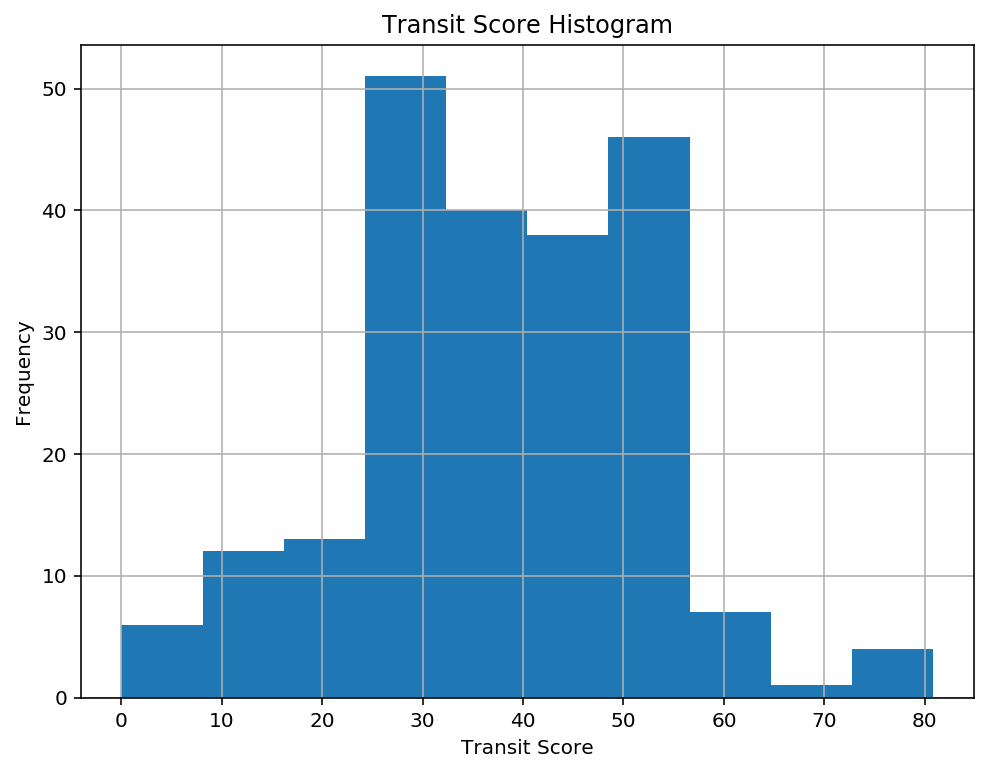

In [479]:
tract_data_all['Transit'].hist()
plt.title('Transit Score Histogram')
plt.xlabel('Transit Score')
plt.ylabel('Frequency')

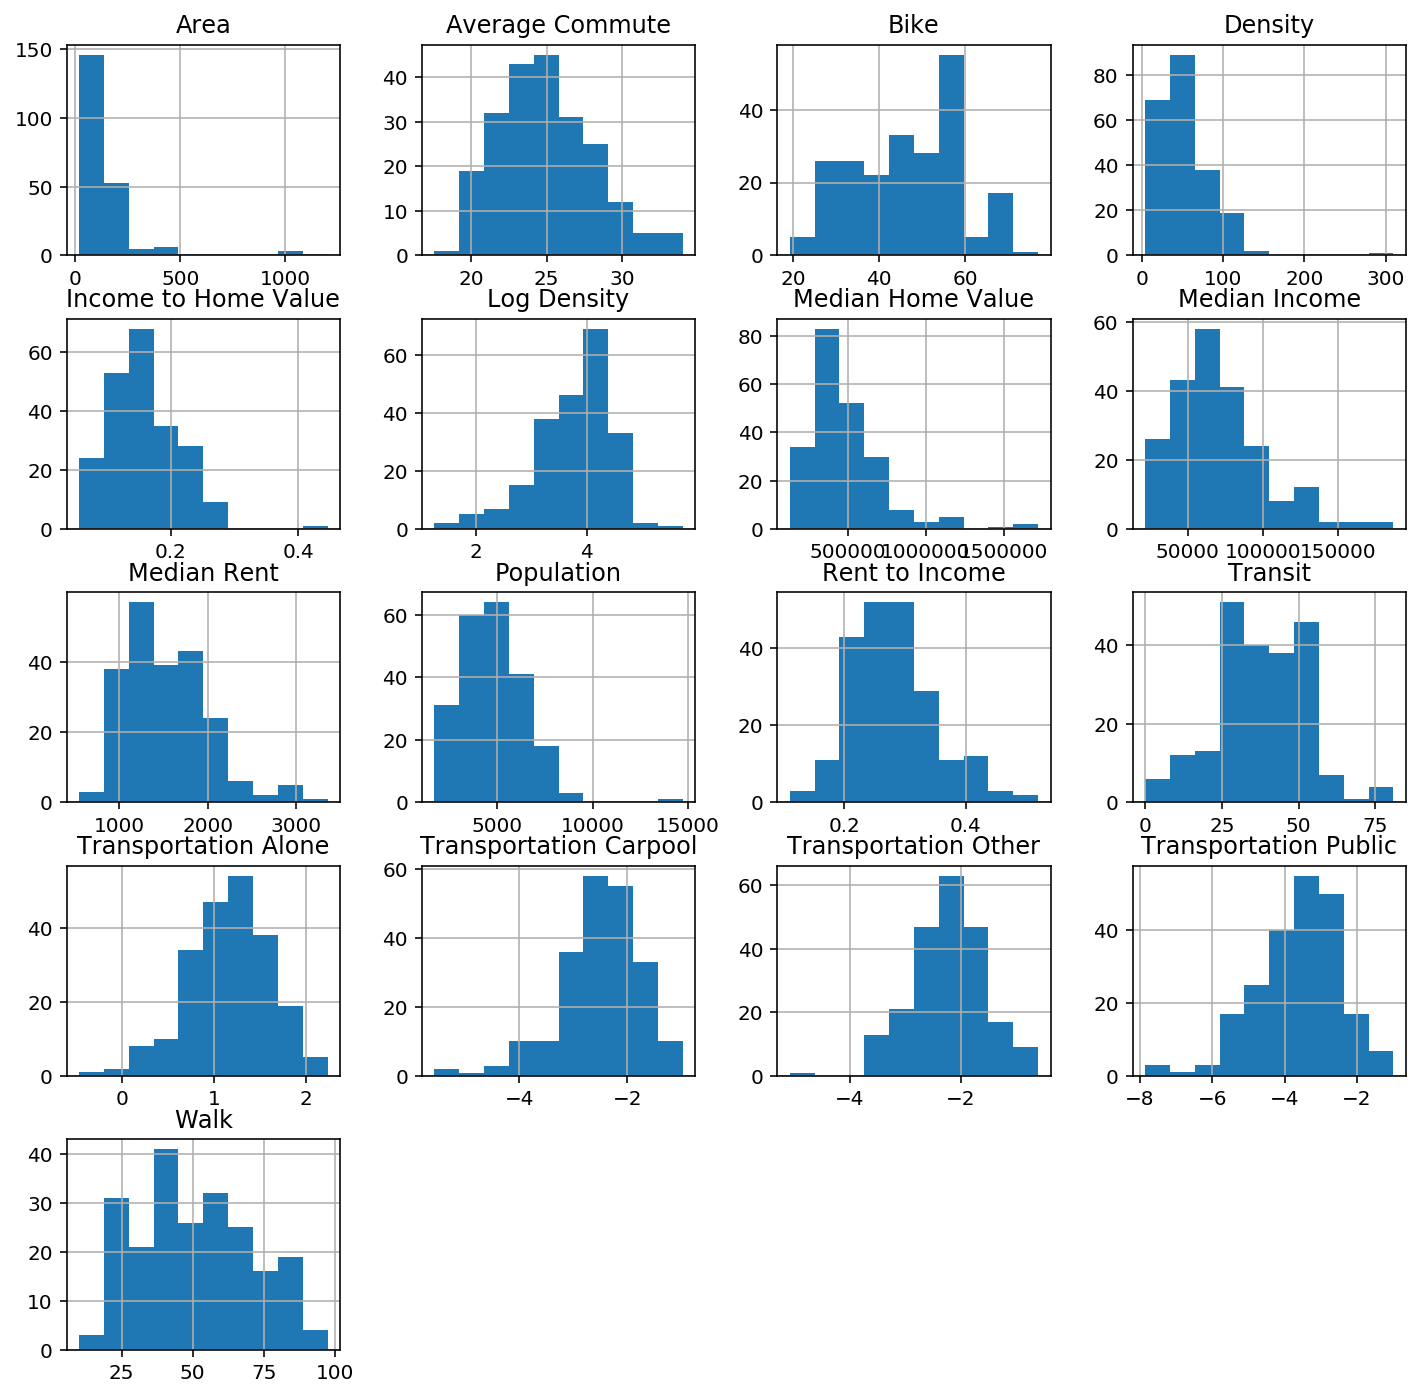

In [209]:
hist = tract_data_all[cols[1:]].hist(figsize=(12,12))

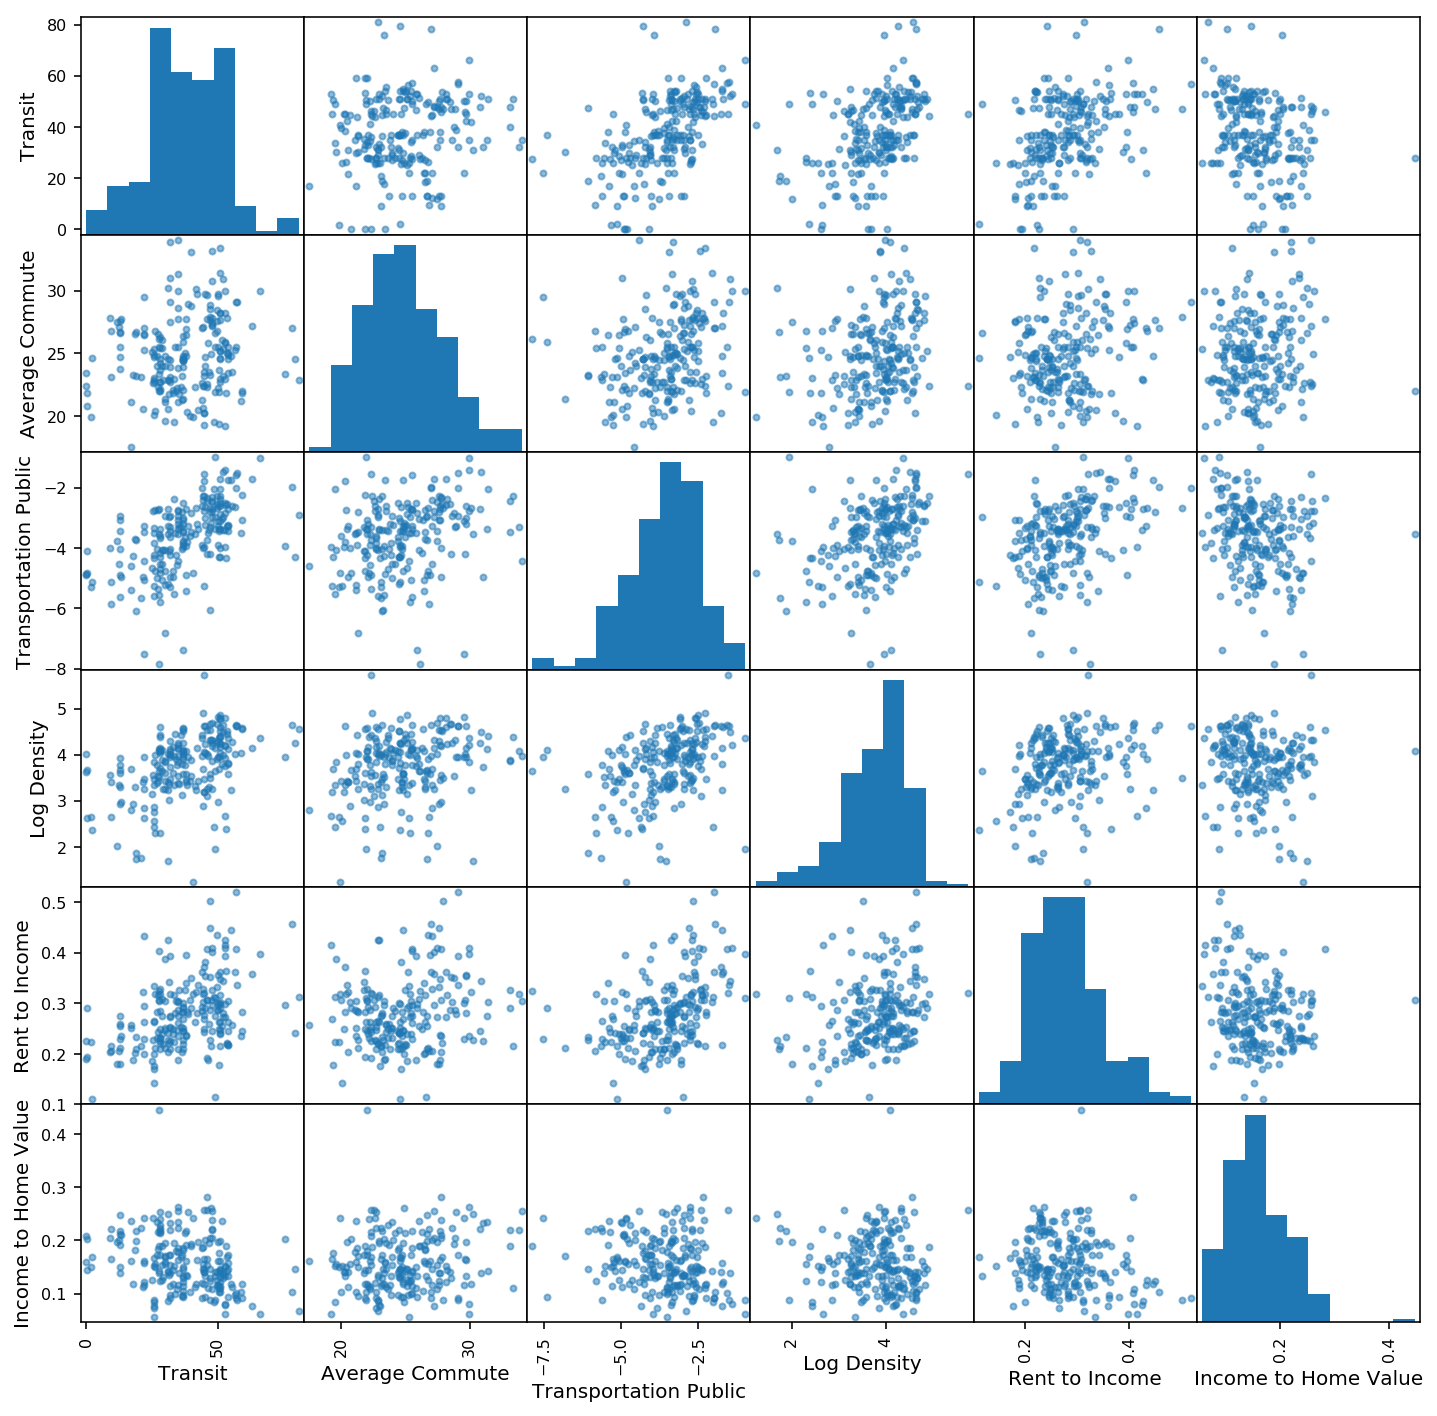

In [210]:
scatter_mat = pd.scatter_matrix(tract_data_all[
    [
        'Transit',
        'Average Commute',
        'Transportation Public',
        'Log Density',
        'Rent to Income',
        'Income to Home Value'
    ]
], figsize=(12, 12))

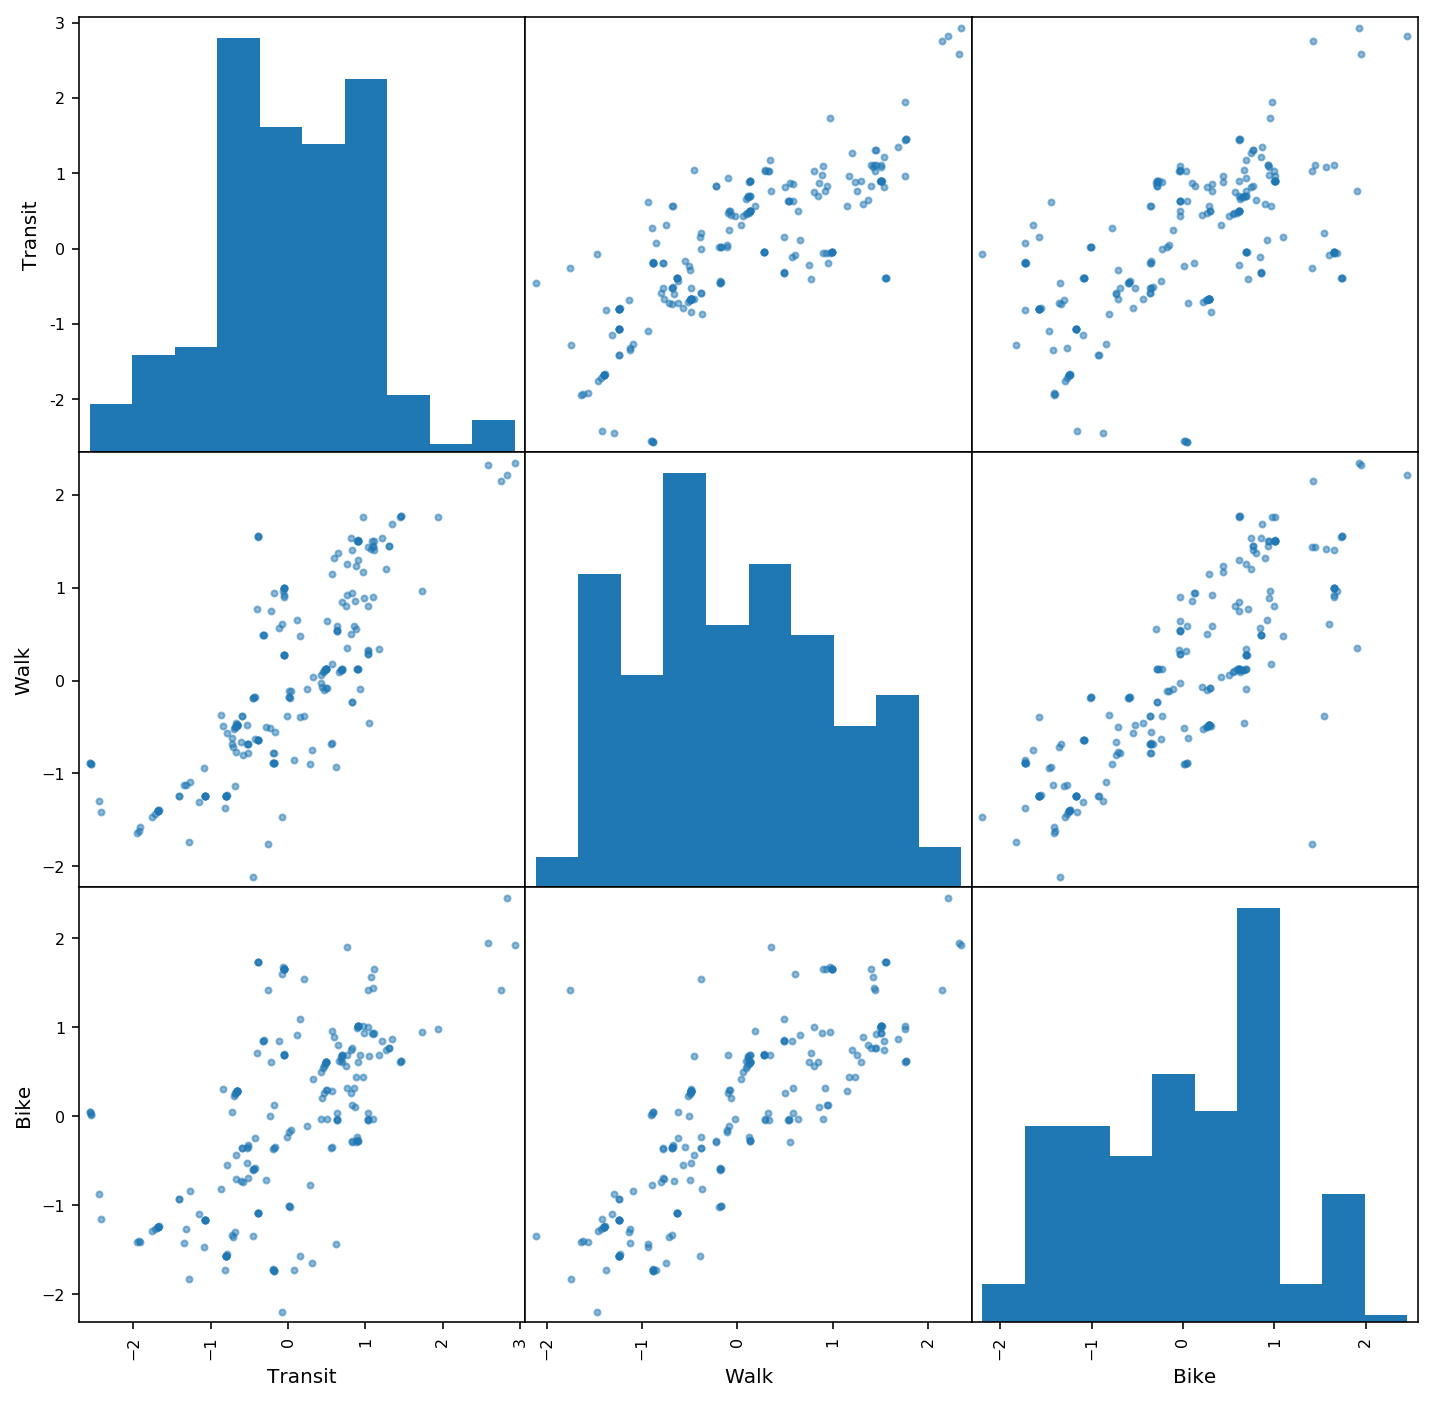

In [211]:
scatter_mat = pd.scatter_matrix(tract_data_all_scaled[
    [
        'Transit',
        'Walk',
        'Bike'
    ]
], figsize=(12, 12))

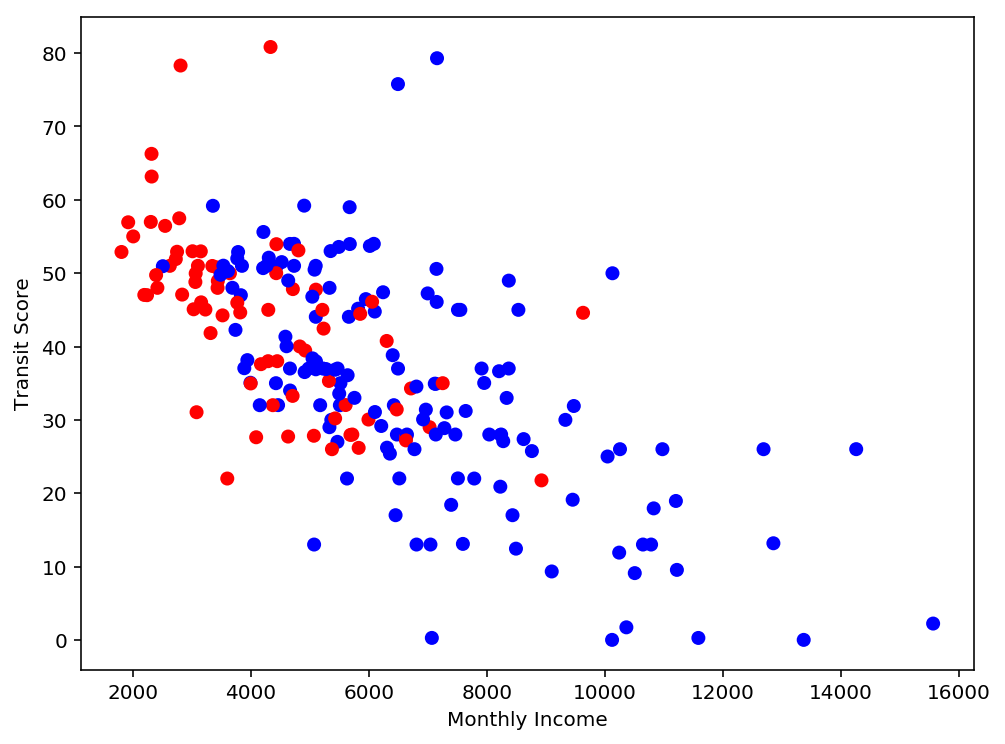

In [426]:
plt.scatter(tract_data_all['Median Income']/12, tract_data_all['Transit'], 
            color=['red' if ratio > .3 else 'blue' for ratio in tract_data_all['Rent to Income']])
plt.xlabel('Monthly Income')
plt.ylabel('Transit Score')

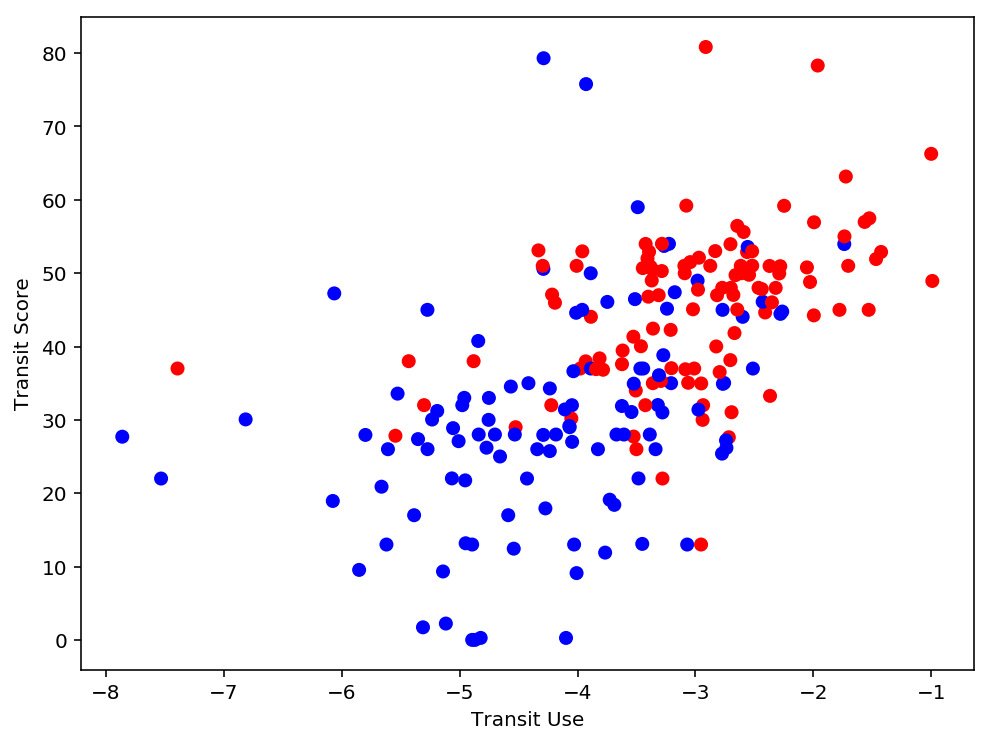

In [420]:
from scipy.special import expit
plt.scatter((tract_data_all['Transportation Public']), tract_data_all['Transit'],
            color=['red' if income < tract_data_all['Median Income'].median()
                       else 'blue' for income in tract_data_all['Median Income']])
plt.xlabel('Transit Use')
plt.ylabel('Transit Score')

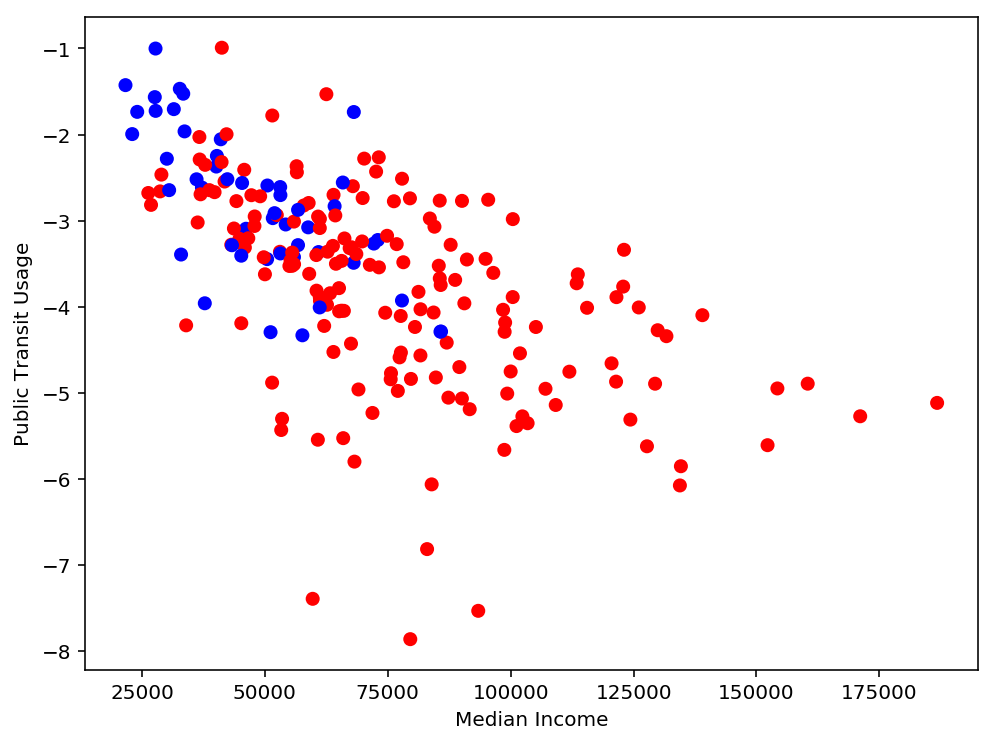

In [286]:
plt.scatter(tract_data_all['Median Income'], (tract_data_all['Transportation Public']),
            color=['red' if transit < 50 else 'blue' for transit in tract_data_all['Transit']])
plt.xlabel('Median Income')
plt.ylabel('Public Transit Usage')

In [421]:
tract_data_all['Median Income'].median()

65344.0

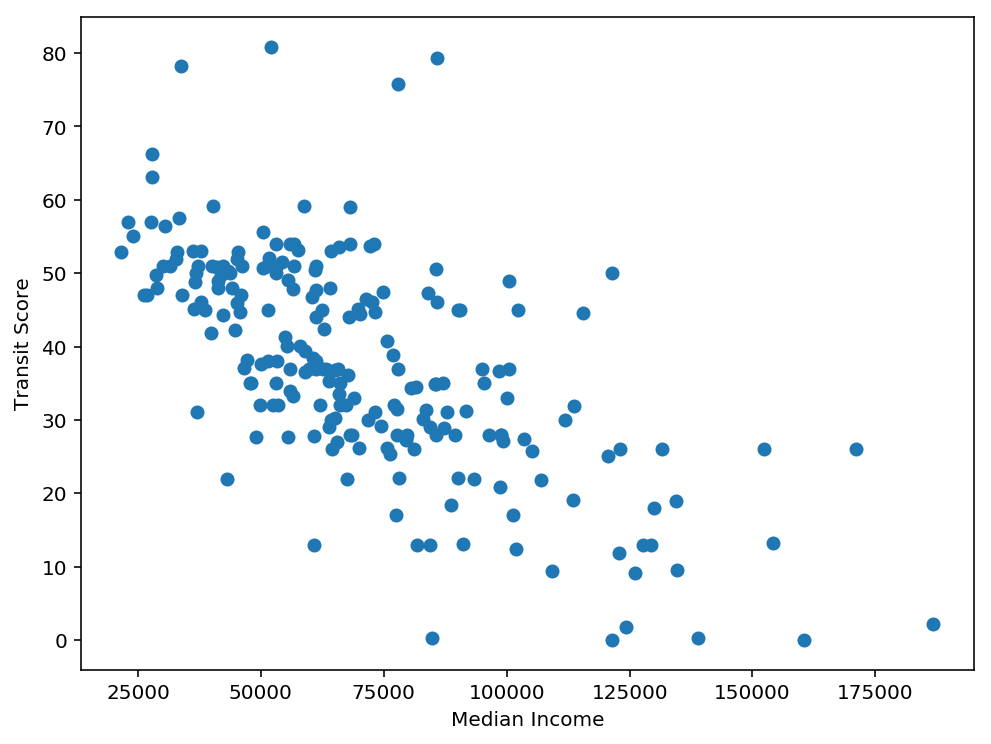

In [215]:
from scipy.special import expit
plt.scatter((tract_data_all['Median Income']), tract_data_all['Transit'])
plt.xlabel('Median Income')
plt.ylabel('Transit Score')

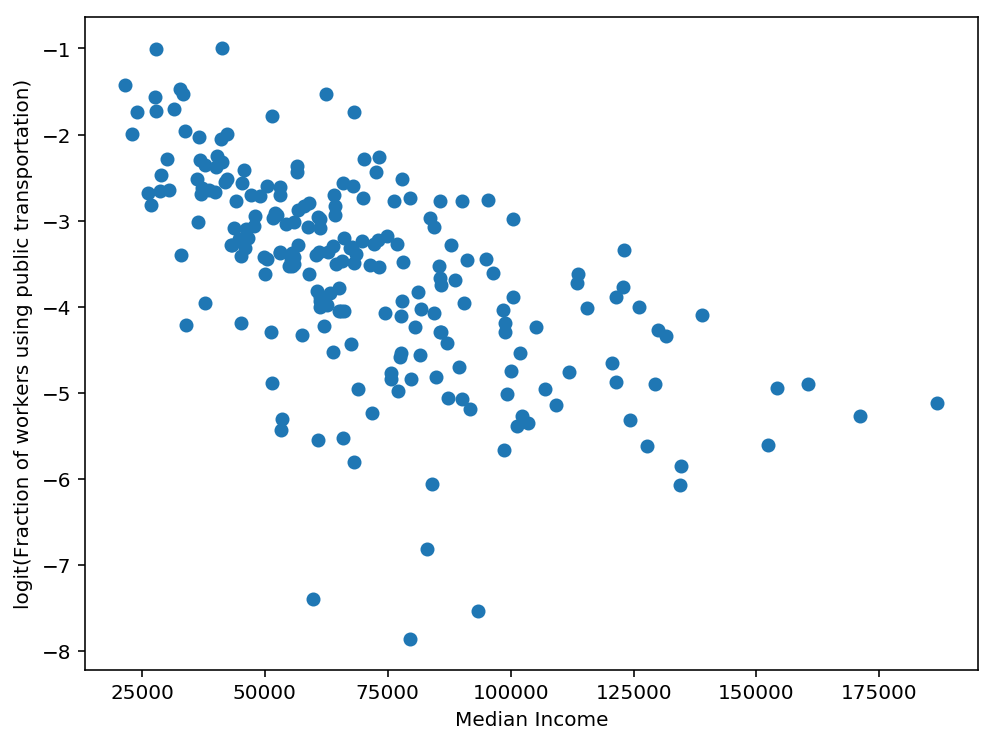

In [216]:
from scipy.special import expit
plt.scatter((tract_data_all['Median Income']), (tract_data_all['Transportation Public']))
plt.xlabel('Median Income')
plt.ylabel('logit(Fraction of workers using public transportation)')

## Maps

In [217]:
import folium

In [218]:
lat = 32.83
lon = -117.2375
zoom_start = 9.5

colors = ['#ffffb2','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#b10026']

In [219]:
def colormap(val, minval, maxval, colors):
    r = np.linspace(minval,maxval+.01,len(colors)+1)
    out = np.where(np.array([(r[i] <= val < r[i+1]) 
                             for i in range(len(colors))]))[0][0]
    return(colors[out])

### Average Commute

In [220]:
m = folium.Map(location=[lat, lon], zoom_start=zoom_start, tiles='Stamen Toner')

mapon = 'Average Commute'
minval = tract_data_all[mapon].min()
maxval = tract_data_all[mapon].max()
for i in range(len(sd_tract_shapes)):
    if sd_tract_ids[i] in list(tract_data_all['Tract']):
        selected = tract_data_all[tract_data_all['Tract'] == sd_tract_ids[i]]
        color_val = selected[mapon].values[0]
        neighborhood_shape = sd_tract_shapes[i].points
        shape = [(lat, lon) for lon, lat in neighborhood_shape]
        color = colormap(color_val, minval, maxval, colors)
        poly = folium.features.PolygonMarker(locations=shape, weight=2, color = 'black', 
                                             fill_color=color)
        m.add_child(poly)
        
m

### Density

In [221]:
m = folium.Map(location=[lat, lon], zoom_start=zoom_start, tiles='Stamen Toner')

mapon = 'Log Density'
minval = tract_data_all[mapon].min()
maxval = tract_data_all[mapon].max()
for i in range(len(sd_tract_shapes)):
    if sd_tract_ids[i] in list(tract_data_all['Tract']):
        selected = tract_data_all[tract_data_all['Tract'] == sd_tract_ids[i]]
        color_val = selected[mapon].values[0]
        neighborhood_shape = sd_tract_shapes[i].points
        shape = [(lat, lon) for lon, lat in neighborhood_shape]
        poly = folium.features.PolygonMarker(locations=shape, weight=2, color = 'black', 
                                             fill_color=colormap(color_val, minval, maxval, colors))
        m.add_child(poly)
        
m

### Transit

In [222]:
m = folium.Map(location=[lat, lon], zoom_start=zoom_start, tiles='Stamen Terrain')

mapon = 'Transit'
minval = tract_data_all[mapon].min()
maxval = tract_data_all[mapon].max()
for i in range(len(sd_tract_shapes)):
    if sd_tract_ids[i] in list(tract_data_all['Tract']):
        selected = tract_data_all[tract_data_all['Tract'] == sd_tract_ids[i]]
        color_val = selected[mapon].values[0]
        neighborhood_shape = sd_tract_shapes[i].points
        shape = [(lat, lon) for lon, lat in neighborhood_shape]
        poly = folium.features.PolygonMarker(locations=shape, weight=2, color = 'black', 
                                             fill_color=colormap(color_val, minval, maxval, colors))
        m.add_child(poly)
        
m

### Rent to Income

In [223]:
m = folium.Map(location=[lat, lon], zoom_start=zoom_start, tiles='Stamen Terrain')

mapon = 'Rent to Income'
minval = tract_data_all[mapon].min()
maxval = tract_data_all[mapon].max()
for i in range(len(sd_tract_shapes)):
    if sd_tract_ids[i] in list(tract_data_all['Tract']):
        selected = tract_data_all[tract_data_all['Tract'] == sd_tract_ids[i]]
        color_val = selected[mapon].values[0]
        neighborhood_shape = sd_tract_shapes[i].points
        shape = [(lat, lon) for lon, lat in neighborhood_shape]
        poly = folium.features.PolygonMarker(locations=shape, weight=2, color = 'black', 
                                             fill_color=colormap(color_val, minval, maxval, colors))
        m.add_child(poly)
        
m

### Rent

In [224]:
m = folium.Map(location=[lat, lon], zoom_start=zoom_start, tiles='Stamen Toner')

mapon = 'Median Rent'
minval = tract_data_all[mapon].min()
maxval = tract_data_all[mapon].max()
for i in range(len(sd_tract_shapes)):
    if sd_tract_ids[i] in list(tract_data_all['Tract']):
        selected = tract_data_all[tract_data_all['Tract'] == sd_tract_ids[i]]
        color_val = selected[mapon].values[0]
        neighborhood_shape = sd_tract_shapes[i].points
        shape = [(lat, lon) for lon, lat in neighborhood_shape]
        poly = folium.features.PolygonMarker(locations=shape, weight=2, color = 'black', 
                                             fill_color=colormap(color_val, minval, maxval, colors))
        m.add_child(poly)
        
m

# Data Analysis and Results

The data

In [225]:
tract_data_all.head()

,Tract,Walk,Transit,Bike,Population,Average Commute,Transportation Alone,Transportation Carpool,Transportation Public,Transportation Other,Median Income,Median Rent,Median Home Value,Area,Density,Log Density,Rent to Income,Income to Home Value
0,4,79.887327,53.972435,57.962561,3606,23.399427,0.823935,-3.042773,-1.738209,-2.092193,68099.0,1238.0,433600.0,81.154666,44.433674,3.793998,0.218153,0.157055
1,21,75.606516,50.690119,51.899553,4842,23.657182,1.556179,-2.796316,-3.446473,-2.366058,50465.0,1048.0,469000.0,62.338649,77.672520,4.352502,0.249202,0.107601
2,33.03,61.946888,47.079668,46.013278,4469,28.527035,0.784581,-0.974727,-4.215824,-3.669796,33995.0,999.0,263600.0,42.501400,105.149478,4.655383,0.352640,0.128964
3,39.01,79.895954,56.939457,55.939457,4456,29.132022,0.602083,-1.876549,-1.994506,-2.182858,23023.0,997.0,253600.0,43.846722,101.626754,4.621307,0.519654,0.090785
4,57,86.113748,59.186133,54.124088,1728,21.871445,0.656292,-2.739645,-2.248191,-1.480226,40250.0,946.0,441700.0,18.290629,94.474610,4.548331,0.282037,0.091125


In [226]:
tract_data_all_scaled.head()

,Tract,Walk,Transit,Bike,Population,Average Commute,Transportation Alone,Transportation Carpool,Transportation Public,Transportation Other,Median Income,Median Rent,Median Home Value,Area,Density,Log Density,Rent to Income,Income to Home Value
0,4,1.450275,1.103601,0.927244,-0.694046,-0.478291,-0.757377,-0.721166,1.599800,0.182193,-0.088111,-0.640471,-0.186288,-0.374178,-0.250844,0.043102,-0.910432,-0.024624
1,21,1.231914,0.880395,0.438057,0.045381,-0.396235,0.879913,-0.390359,0.142658,-0.222598,-0.680674,-1.047285,-0.036278,-0.483594,0.747125,0.852990,-0.454778,-0.956356
2,33.03,0.535148,0.634875,-0.036872,-0.177763,1.154081,-0.845371,2.054670,-0.513597,-2.149613,-1.234122,-1.152200,-0.906674,-0.598948,1.572099,1.292199,1.063182,-0.553865
3,39.01,1.450715,1.305366,0.764012,-0.185540,1.346678,-1.253435,0.844199,1.381180,0.048184,-1.602819,-1.156483,-0.949050,-0.591125,1.466332,1.242785,3.514135,-1.273189
4,57,1.767879,1.458146,0.617541,-1.817544,-0.964723,-1.132225,-0.314292,1.164788,1.086722,-1.023933,-1.265680,-0.151963,-0.739735,1.251595,1.136963,0.027077,-1.266774


## Ordinary least squares

### Predicting Commute Time

In [227]:
import patsy
import statsmodels.api as sm
outcome, predictors = patsy.dmatrices("Q('Average Commute') ~ \
                                      Bike  + Walk + Transit + Q('Log Density') + \
                                      Q('Transportation Public') + Q('Transportation Alone') + \
                                      Q('Transportation Carpool') + \
                                      Q('Median Income') + Q('Median Home Value') + Q('Median Rent')",
                                          tract_data_all_scaled)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     Q('Average Commute')   R-squared:                       0.307
Model:                              OLS   Adj. R-squared:                  0.274
Method:                   Least Squares   F-statistic:                     9.181
Date:                  Fri, 09 Jun 2017   Prob (F-statistic):           1.62e-12
Time:                          20:17:44   Log-Likelihood:                -269.32
No. Observations:                   218   AIC:                             560.6
Df Residuals:                       207   BIC:                             597.9
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------

### Predicting Transportation Method

In [434]:
outcome, predictors = patsy.dmatrices("Q('Transportation Public') ~ \
                                      Bike + Walk + Transit + \
                                      Q('Median Income') + Q('Log Density')",
                                      tract_data_all_scaled)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                                OLS Regression Results                                
Dep. Variable:     Q('Transportation Public')   R-squared:                       0.408
Model:                                    OLS   Adj. R-squared:                  0.394
Method:                         Least Squares   F-statistic:                     29.23
Date:                        Sat, 10 Jun 2017   Prob (F-statistic):           1.60e-22
Time:                                00:48:38   Log-Likelihood:                -252.17
No. Observations:                         218   AIC:                             516.3
Df Residuals:                             212   BIC:                             536.6
Df Model:                                   5                                         
Covariance Type:                    nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------

In [435]:
res.pvalues

array([  1.00000000e+00,   9.27976114e-01,   2.43004178e-01,
         4.27209518e-04,   2.14298893e-06,   9.24842131e-02])

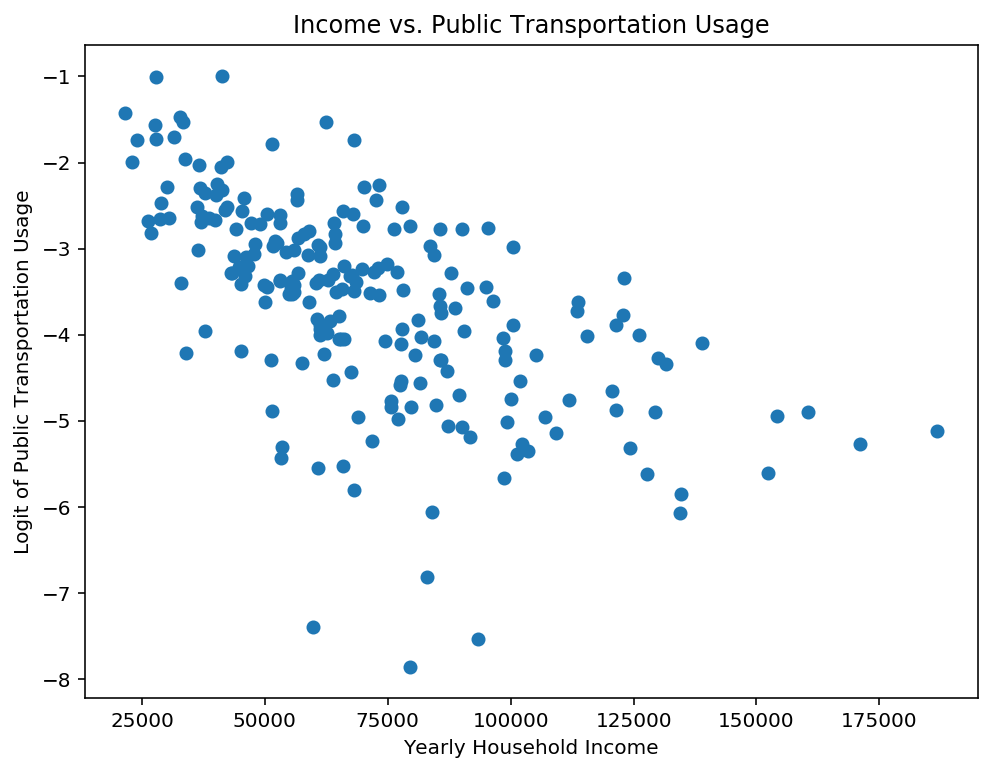

In [441]:
plt.scatter(tract_data_all['Median Income'], tract_data_all['Transportation Public'])
plt.xlabel('Yearly Household Income')
plt.ylabel('Logit of Public Transportation Usage')
plt.title('Income vs. Public Transportation Usage')

In [268]:
outcome, predictors = patsy.dmatrices("Q('Transportation Alone') ~ \
                                      Bike + Walk + Transit + Q('Log Density') + \
                                      Q('Median Income')",
                                      tract_data_all_scaled)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                                OLS Regression Results                               
Dep. Variable:     Q('Transportation Alone')   R-squared:                       0.274
Model:                                   OLS   Adj. R-squared:                  0.257
Method:                        Least Squares   F-statistic:                     16.01
Date:                       Fri, 09 Jun 2017   Prob (F-statistic):           2.23e-13
Time:                               21:08:42   Log-Likelihood:                -274.41
No. Observations:                        218   AIC:                             560.8
Df Residuals:                            212   BIC:                             581.1
Df Model:                                  5                                         
Covariance Type:                   nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------

In [269]:
outcome, predictors = patsy.dmatrices("Q('Transportation Carpool')  ~ \
                                      Bike + Walk + Transit + Q('Log Density') + \
                                      Q('Median Income')",
                                      tract_data_all_scaled)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:     Q('Transportation Carpool')   R-squared:                       0.140
Model:                                     OLS   Adj. R-squared:                  0.120
Method:                          Least Squares   F-statistic:                     6.925
Date:                         Fri, 09 Jun 2017   Prob (F-statistic):           5.19e-06
Time:                                 21:09:02   Log-Likelihood:                -292.84
No. Observations:                          218   AIC:                             597.7
Df Residuals:                              212   BIC:                             618.0
Df Model:                                    5                                         
Covariance Type:                     nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------

In [235]:
outcome, predictors = patsy.dmatrices("Q('Transportation Other') ~ \
                                      Bike + Walk + Transit + Q('Log Density') + \
                                      Q('Median Income') + Q('Median Home Value') + Q('Median Rent') + \
                                      Q('Rent to Income')",
                                      tract_data_all_scaled)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                                OLS Regression Results                               
Dep. Variable:     Q('Transportation Other')   R-squared:                       0.448
Model:                                   OLS   Adj. R-squared:                  0.427
Method:                        Least Squares   F-statistic:                     21.19
Date:                       Fri, 09 Jun 2017   Prob (F-statistic):           2.09e-23
Time:                               20:17:45   Log-Likelihood:                -244.59
No. Observations:                        218   AIC:                             507.2
Df Residuals:                            209   BIC:                             537.6
Df Model:                                  8                                         
Covariance Type:                   nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------

### Predicting Income

In [236]:
outcome, predictors = patsy.dmatrices("Q('Median Income') ~ \
                                      Bike + Walk + Transit + Q('Log Density') + Q('Average Commute')",
                                      tract_data_all_scaled)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     Q('Median Income')   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     46.85
Date:                Fri, 09 Jun 2017   Prob (F-statistic):           1.76e-32
Time:                        20:17:45   Log-Likelihood:                -228.20
No. Observations:                 218   AIC:                             468.4
Df Residuals:                     212   BIC:                             488.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept             3.469e-17 

### Predicting Rent as a Fraction of Income

In [423]:
outcome, predictors = patsy.dmatrices("Q('Rent to Income') ~ \
                                      Bike + Walk + Transit + Q('Log Density') + Q('Average Commute')",
                                      tract_data_all_scaled)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     Q('Rent to Income')   R-squared:                       0.238
Model:                             OLS   Adj. R-squared:                  0.220
Method:                  Least Squares   F-statistic:                     13.27
Date:                 Fri, 09 Jun 2017   Prob (F-statistic):           2.94e-11
Time:                         23:22:23   Log-Likelihood:                -279.64
No. Observations:                  218   AIC:                             571.3
Df Residuals:                      212   BIC:                             591.6
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept             

### Predicting Income as a Fraction of Home Value

In [244]:
outcome, predictors = patsy.dmatrices("Q('Income to Home Value') ~ \
                                      Bike + Walk + Transit + Q('Log Density') + Q('Average Commute')",
                                      tract_data_all_scaled)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                                OLS Regression Results                               
Dep. Variable:     Q('Income to Home Value')   R-squared:                       0.230
Model:                                   OLS   Adj. R-squared:                  0.211
Method:                        Least Squares   F-statistic:                     12.64
Date:                       Fri, 09 Jun 2017   Prob (F-statistic):           9.39e-11
Time:                               20:17:47   Log-Likelihood:                -280.89
No. Observations:                        218   AIC:                             573.8
Df Residuals:                            212   BIC:                             594.1
Df Model:                                  5                                         
Covariance Type:                   nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------

### Predicting home value

In [245]:
outcome, predictors = patsy.dmatrices("Q('Median Home Value') ~ \
                                      Bike + Walk + Transit + Q('Log Density') + Q('Average Commute')",
                                      tract_data_all_scaled)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     Q('Median Home Value')   R-squared:                       0.319
Model:                                OLS   Adj. R-squared:                  0.303
Method:                     Least Squares   F-statistic:                     19.86
Date:                    Fri, 09 Jun 2017   Prob (F-statistic):           3.20e-16
Time:                            20:17:47   Log-Likelihood:                -267.45
No. Observations:                     218   AIC:                             546.9
Df Residuals:                         212   BIC:                             567.2
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------

In [246]:
outcome, predictors = patsy.dmatrices("Q('Median Rent') ~ \
                                      Bike + Walk + Transit + Q('Log Density') + Q('Average Commute')",
                                      tract_data_all_scaled)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       Q('Median Rent')   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     29.05
Date:                Fri, 09 Jun 2017   Prob (F-statistic):           2.09e-22
Time:                        20:17:47   Log-Likelihood:                -252.45
No. Observations:                 218   AIC:                             516.9
Df Residuals:                     212   BIC:                             537.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept             9.021e-17 

### Predicting Transit Score

In [443]:
outcome, predictors = patsy.dmatrices("Transit ~ \
                                      Q('Median Income')+ \
                                      Q('Log Density') + Q('Transportation Public') + \
                                      Walk + Bike",
                                      tract_data_all_scaled)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Transit   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     126.6
Date:                Sat, 10 Jun 2017   Prob (F-statistic):           1.24e-61
Time:                        01:24:29   Log-Likelihood:                -158.64
No. Observations:                 218   AIC:                             329.3
Df Residuals:                     212   BIC:                             349.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

In [444]:
res.pvalues

array([  1.00000000e+00,   2.48113158e-09,   3.90038592e-02,
         4.27209518e-04,   3.59342807e-22,   4.18723002e-02])

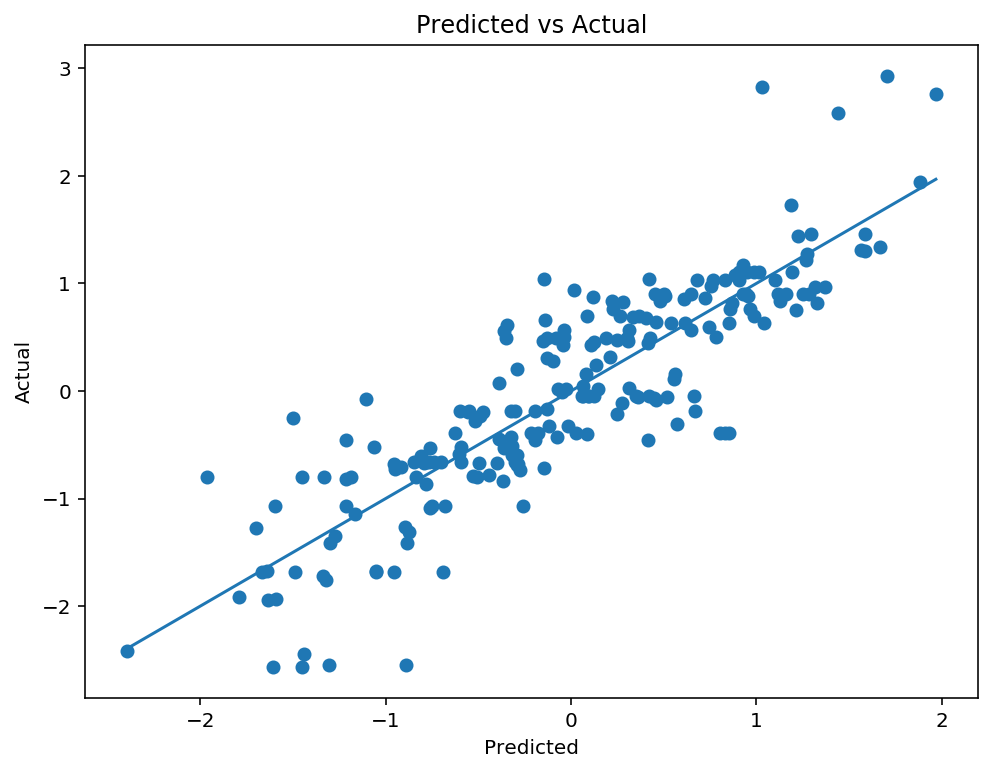

In [292]:
plt.scatter(res.predict(),outcome)
mn = min(res.predict())
mx = max(res.predict())
plt.plot([mn,mx], [mn,mx])
plt.title('Predicted vs Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')

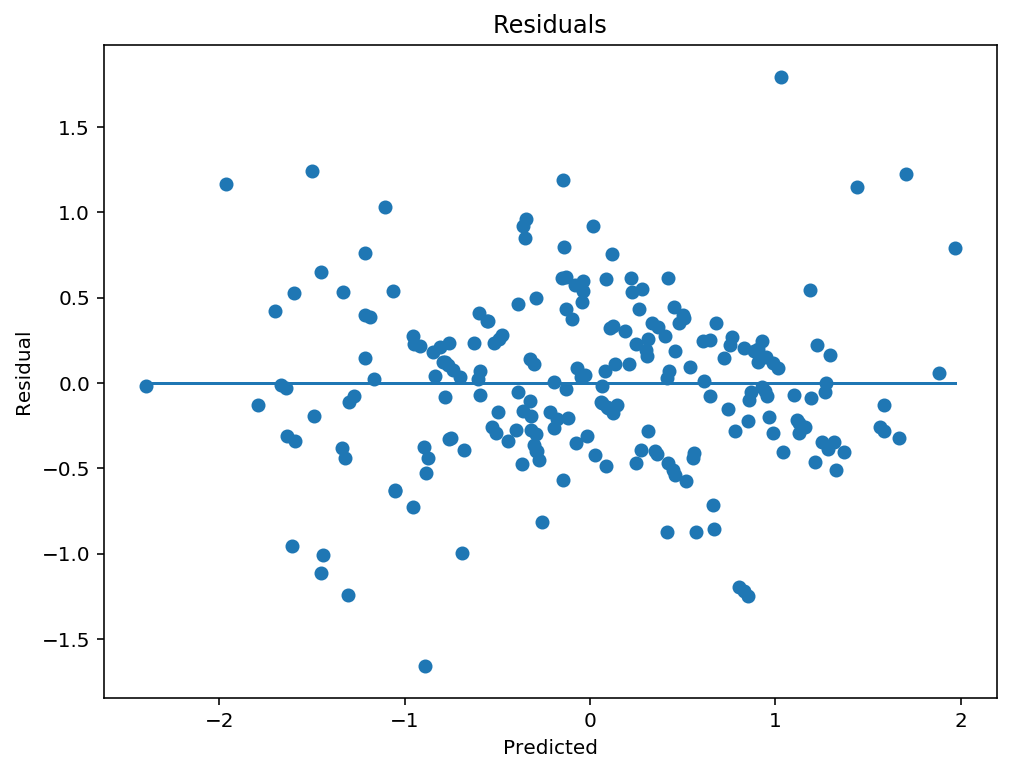

In [293]:
plt.scatter(res.predict(),res.resid)
mn = min(res.predict())
mx = max(res.predict())
plt.plot([mn,mx], [0,0])
plt.title('Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residual')

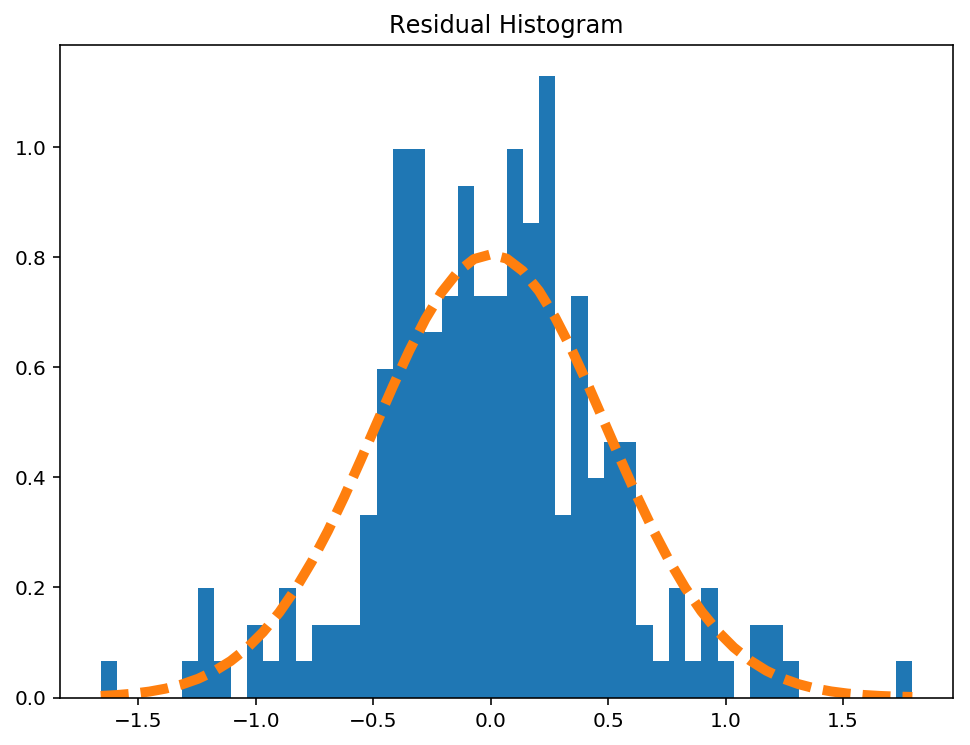

In [294]:
weights = np.ones_like(res.resid)/len(res.resid)

n, bins, patches = plt.hist(res.resid, 50, normed=True, weights=weights)
mu = np.mean(res.resid)
sigma = np.std(res.resid)
plt.plot(bins, mlab.normpdf(bins, mu, sigma), '--', linewidth=5.0)
plt.title('Residual Histogram')

## High transit usage neighborhoods with low transit score

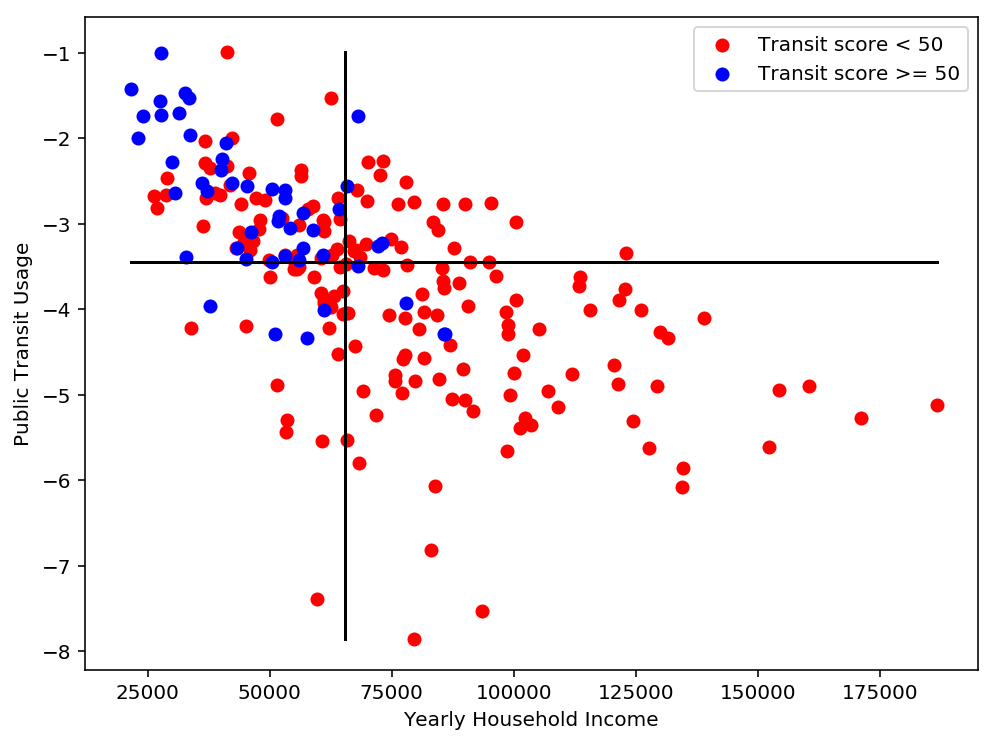

In [459]:
bad_transit = tract_data_all[tract_data_all['Transit'] < 50]
good_transit = tract_data_all[tract_data_all['Transit'] >= 50]

plt.scatter(bad_transit['Median Income'], bad_transit['Transportation Public'], color = 'red')
plt.scatter(good_transit['Median Income'], good_transit['Transportation Public'], color = 'blue')

plt.xlabel('Yearly Household Income')
plt.ylabel('Public Transit Usage')
plt.legend(['Transit score < 50', 'Transit score >= 50'])

p_trans = np.percentile(tract_data_all['Transportation Public'], 50)
mn_trans = min(tract_data_all['Median Income'])
mx_trans = max((tract_data_all['Median Income']))
plt.plot([mn_trans,mx_trans],[p_trans,p_trans], color = 'black')

p_income = np.percentile(tract_data_all['Median Income'], 50)
mn_income = min(tract_data_all['Transportation Public'])
mx_income = max((tract_data_all['Transportation Public']))
plt.plot([p_income,p_income], [mn_income,mx_income], color = 'black')

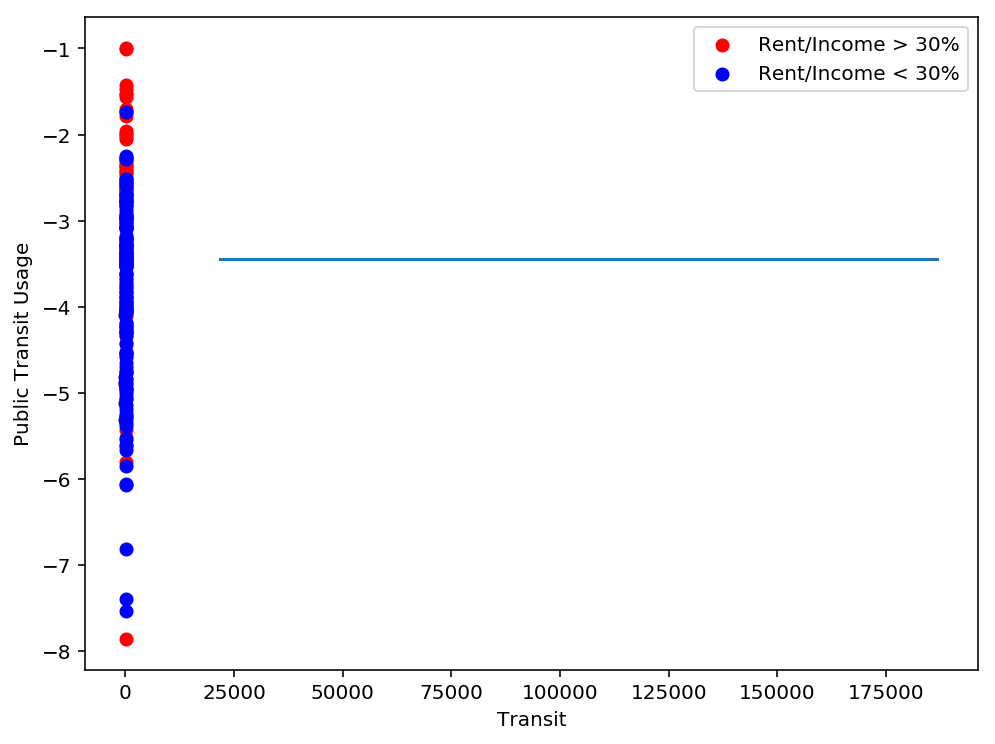

In [456]:
good_income = tract_data_all[tract_data_all['Rent to Income'] < .30]
bad_income = tract_data_all[tract_data_all['Rent to Income'] >= .30]

plt.scatter(bad_income['Transit'], bad_income['Transportation Public'], color = 'red')
plt.scatter(good_income['Transit'], good_income['Transportation Public'], color = 'blue')

plt.xlabel('Transit')
plt.ylabel('Public Transit Usage')
plt.legend(['Rent/Income > 30%', 'Rent/Income < 30%'])

p_trans = np.percentile(tract_data_all['Transportation Public'], 50)
mn_trans = min(tract_data_all['Median Income'])
mx_trans = max((tract_data_all['Median Income']))
plt.plot([mn_trans,mx_trans],[p_trans,p_trans])

# p_income = np.percentile(tract_data_all['Median Income'], 50)
# mn_income = min(tract_data_all['Transportation Public'])
# mx_income = max((tract_data_all['Transportation Public']))
# plt.plot([p_income,p_income], [mn_income,mx_income])

In [460]:
underserved = bad_transit[(bad_transit['Transportation Public'] > p_trans) & (bad_transit['Median Income'] < p_income)]

In [465]:
underserved['Population'].sum() / tract_data_all['Population'].sum()

0.20606071688775662

In [469]:
(underserved['Rent to Income'] < .3).mean()

0.37777777777777777

In [474]:
(tract_data_all[(tract_data_all['Transportation Public'] > p_trans) & (tract_data_all['Median Income'] < p_income)]['Rent to Income'] < .3).mean()

0.41975308641975306

In [475]:
from scipy.stats import ttest_ind

In [476]:
ttest_ind(underserved['Rent to Income'] < .3,
          tract_data_all[(tract_data_all['Transportation Public'] > p_trans) & (tract_data_all['Median Income'] < p_income)]['Rent to Income'] < .3)

Ttest_indResult(statistic=-0.45667021470857772, pvalue=0.64870704171167182)

In [466]:
m = folium.Map(location=[lat, lon], zoom_start=zoom_start, tiles='Stamen Terrain')

for i in range(len(sd_tract_shapes)):
    if sd_tract_ids[i] in list(underserved['Tract']):
        selected = tract_data_all[tract_data_all['Tract'] == sd_tract_ids[i]]
        neighborhood_shape = sd_tract_shapes[i].points
        shape = [(lat, lon) for lon, lat in neighborhood_shape]
        poly = folium.features.PolygonMarker(locations=shape, weight=2, color = 'black', 
                                             fill_color='red')
        m.add_child(poly)
        
m

# Conclusions/Discussion

Population density is strongly positively correlated with commute time, i.e. neighborhoods with high population density have a higher average commute time.

We found that Bike score is negatively correlated with commute time while Transit score is positively correlated with commute time, even after controlling for population density. Bike score is likely related to commute time through bike infrastructure rather than geography since Walk score is uncorrelated to commute time, and we would expect walkable geography to be bikeable as well.


Why would bike infrastructure reduce commute times?
Hypothesis: bikers reduce traffic congestion
 
Why is Transit score positively correlated with commute time? Does this refute our initial hypothesis at the top of this page?

* Hypothesis: Congested neighborhoods build transit infrastructure, but it has little effect on alleviating congestion
 
* This may refute our first hypothesis, but we still wish to control for other possibly confounding variables. Question: does more public transportation infrastructure lead to more adoption of public transit as a means of getting around?


**TODO** Add other regressors to see if they explain more of the variance 

* Earnings
* Industry
* Race
* Sex

Next questions (**TODO by Saturday**):

* Can we predict transit method based on congestion levels (inferred from commute times) and bike/walk/transit scores? (And other regressors listed above)
* Explore relationship of commute time per method of transportation, relationship between bike lanes, walk time, transport time and income.
* Can we predict income from transit access?